In [15]:
import numpy as np
import pandas as pd
import scanpy as sc
import os


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


fn = "./patient_files/cellranger_output/MantonBM1_HiSeq_1/raw_feature_bc_matrix.h5"
class sst_toolset:
    def __init__(self, fn):
        """Initialize the class with a filename and smaple name to referene throughout"""
        self.fn = fn
        self.sample_name = os.path.basename(os.path.dirname(fn))
        self.adata =  sc.read_10x_h5(fn)


    def filter_function(self):
        """ Load data and Filter the transcriptomic data with predefined settings

        Args:
            fn (str): name of file to perform filtering
        Returns: AnnData object
        
        """

        self.adata.var_names_make_unique()

        # affect self.adata in place
        sc.pp.filter_cells(self.adata, min_genes=500) 

        self.adata.var['mt'] = self.adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

        # create qc metrics on adata in place and filter based on these calcuatled metrics
        sc.pp.calculate_qc_metrics(self.adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        self.adata = self.adata[self.adata.obs.n_genes_by_counts < 6000, :]
        self.adata = self.adata[self.adata.obs.pct_counts_mt < 10, :]

        # total count normalize the data
        sc.pp.normalize_total(self.adata, target_sum=100000)

        # idneitfy highly variable genes
        sc.pp.log1p(self.adata)
        sc.pp.highly_variable_genes(self.adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
        sc.pl.highly_variable_genes(self.adata, show=False )

        # keep top 2000 variable genes
        sc.pp.filter_genes_dispersion(self.adata, n_top_genes=2000)

    def umap_plotter(self):
        """Function to create a umap plot with leiden coloring"""
        sc.tl.pca(self.adata, svd_solver='arpack')
        sc.pl.pca(self.adata, color='CST3', show = False)
        sc.pl.pca_variance_ratio(self.adata, log=True, show=False)

        sc.pp.neighbors(self.adata, n_neighbors=100)


        sc.tl.leiden(self.adata, 1.3)

        sc.tl.paga(self.adata)
        sc.pl.paga(self.adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
        sc.tl.umap(self.adata, init_pos='paga')

        sc.tl.umap(self.adata)
        
        sc.pl.umap(self.adata, color=['leiden'], save=f"{self.sample_name}.png", show=False)

    def gene_rank_plotter(self):
        # gene rank plot
        sc.tl.rank_genes_groups(self.adata, 'leiden', method='wilcoxon')

        sc.pl.rank_genes_groups(self.adata, n_genes=25, sharey=False, save=f"{self.sample_name}.png", show=False)

    def saver(self):
        os.makedirs("./output_h5")
        self.adata.write_h5ad(f"./output_h5/{self.sample_name}.h5ad")



scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.2 scikit-learn==1.2.0 statsmodels==0.13.5 python-igraph==0.10.3 pynndescent==0.5.8


reading ./patient_files/cellranger_output/MantonBM1_HiSeq_1/raw_feature_bc_matrix.h5
 (0:00:02)


/Users/leeleavitt/Documents/01092023_genetech_screen/.sst_py/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 297347 cells that have less than 500 genes expressed
normalizing counts per cell


/Users/leeleavitt/Documents/01092023_genetech_screen/.sst_py/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


ValueError: Plot PAGA first, so that adata.uns['paga']with key 'pos'.

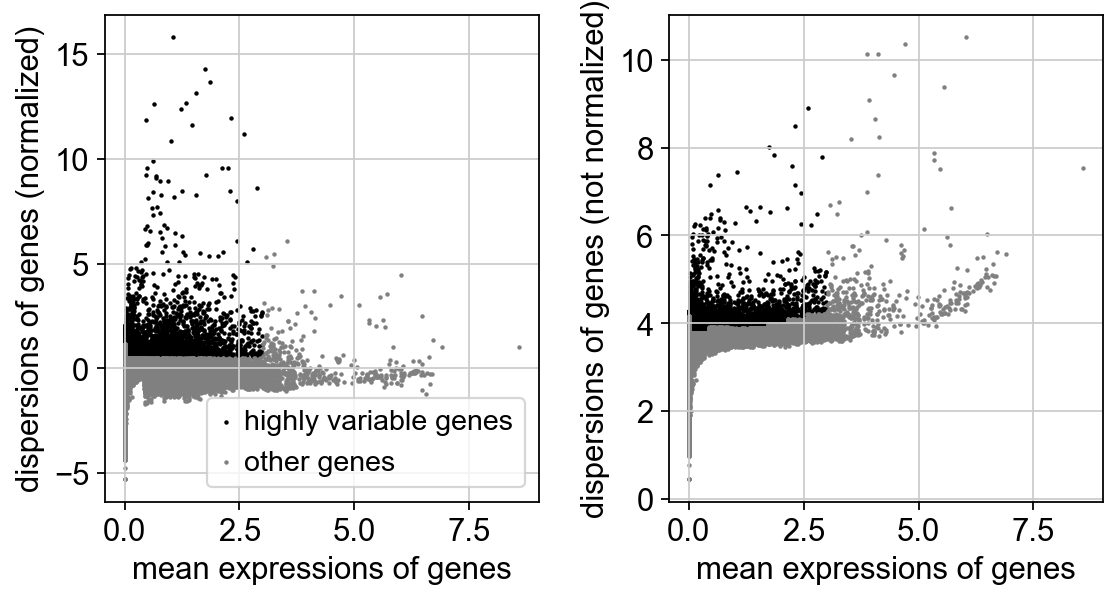

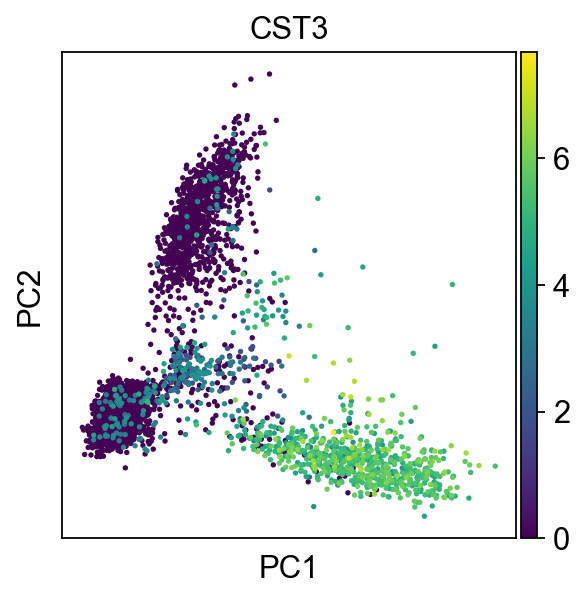

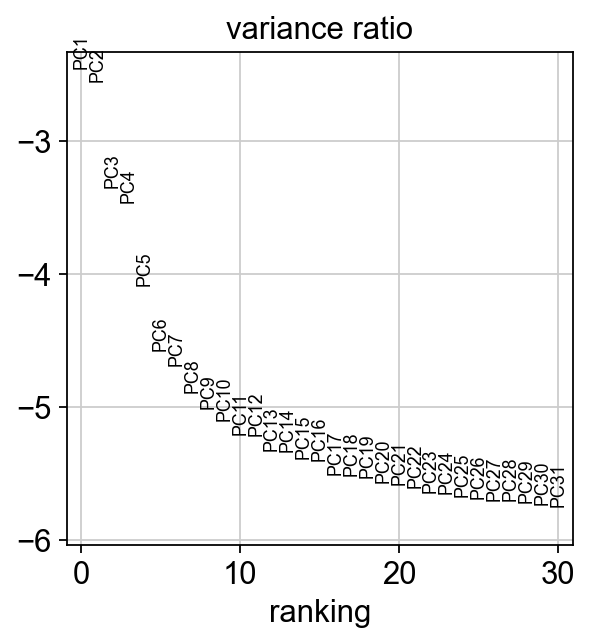

In [16]:
sample_tools = sst_toolset(fn)

sample_tools.filter_function()
sample_tools.umap_plotter()
sample_tools.gene_rank_plotter()

sample_tools.saver()

In [56]:
sample_tools.saver()

The analysis consists of the following steps:
1. Quality control: For cells, keep those with $ 500 \leq$ number of genes expressed $< 6000$, and with percent of
mitochondrial genes (name prefix MT- ) $< 10\%$. For genes, keep those expressed in at least $0.05\%$ of cells.
2. Log-normalize data with $100,000$ reads per cell.
3. Select top 2000 highly variable genes.
4. Get Principal Component Analysis (PCA) embedding with 50 PCs.
5. Get Nearest Neighborhood graph of 100 neighbors from the 50 PCs.
6. Leiden clustering on PCA embedding with resolution 1.3.
7. Calculate UMAP embedding from PCA embedding, and generate UMAP plot with cells colored by their leiden labels.
8. Find marker genes for each leiden cluster using Mann-Whitney-U test, and generate the gene rank plot.